## **importing dependencies**


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np


# **Loading Dataset**

In [ ]:
df = pd.read_csv('cleaned_tf.csv')


# **Combinig title and news description**

In [ ]:
df['combined_text'] = df['title'] + " " + df['description']

In [ ]:
df.head()

,title,description,label,combined_text
0,New tool makes songs unlearnable to generative AI,"Nearly 200 years after Beethovens death, a tea...",1,New tool makes songs unlearnable to generative...
1,Revolutionary Solar Paint Can Turn Any Surface...,Revolutionary solar paint has been developed t...,0,Revolutionary Solar Paint Can Turn Any Surface...
2,"""First Driverless Vehicle Completes a Race Acr...",The first driverless vehicle has successfully ...,0,"""First Driverless Vehicle Completes a Race Acr..."
3,Microsoft AutoDev: Automated AI-Driven Develop...,"Microsoft has launched AutoDev, an AI tool tha...",1,Microsoft AutoDev: Automated AI-Driven Develop...
4,Digital Image Processing Tools Now Detect Obje...,New digital image processing tools powered by ...,0,Digital Image Processing Tools Now Detect Obje...


# **Train Test split**

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['combined_text'], df['label'], test_size=0.2, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# **Bert tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# **Tokenizating texts**

In [ ]:
def tokenize_data(texts, labels):
    # Ensure texts are clean and in the correct format
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").tolist()
    else:
        texts = [str(text) for text in texts]

    # Tokenize the data
    tokenized = tokenizer(
        texts,  # Pass the cleaned list
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": tf.convert_to_tensor(labels, dtype=tf.int32)
    }


In [ ]:
train_dataset = tokenize_data(train_texts, train_labels)
val_dataset = tokenize_data(val_texts, val_labels)
test_dataset = tokenize_data(test_texts, test_labels)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((dict(train_dataset), train_dataset["labels"]))
val_data = tf.data.Dataset.from_tensor_slices((dict(val_dataset), val_dataset["labels"]))




In [ ]:
train_data = train_data.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)


Epoch 1/3
120/120 [==============================] - 3080s 25s/step - loss: 0.1606 - accuracy: 0.9396 - val_loss: 0.0260 - val_accuracy: 0.9938
Epoch 2/3
120/120 [==============================] - 3208s 27s/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0387 - val_accuracy: 0.9854
Epoch 3/3
120/120 [==============================] - 3067s 26s/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0753 - val_accuracy: 0.9896


In [ ]:

test_data = tf.data.Dataset.from_tensor_slices((dict(test_dataset), test_dataset["labels"]))
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)





In [ ]:
results = model.evaluate(test_data)
print(f"Test Accuracy: {results[1]}")

38/38 [==============================] - 272s 7s/step - loss: 0.0745 - accuracy: 0.9884
Test Accuracy: 0.9883527159690857


In [ ]:
y_pred = tf.argmax(model.predict(test_data).logits, axis=1)
print(classification_report(test_labels, y_pred.numpy(), target_names=["Fake", "True"]))

38/38 [==============================] - 274s 7s/step
              precision    recall  f1-score   support

        Fake       1.00      0.98      0.99       310
        True       0.98      1.00      0.99       291

    accuracy                           0.99       601
   macro avg       0.99      0.99      0.99       601
weighted avg       0.99      0.99      0.99       601



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

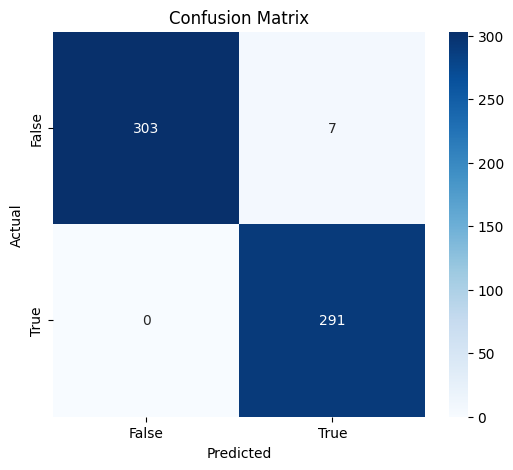

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os


model_save_path = "/content/drive/MyDrive/saved_bert_model"


os.makedirs(model_save_path, exist_ok=True)


model.save_pretrained(model_save_path)

In [ ]:
model_path = "/content/drive/MyDrive/saved_bert_model"

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(model_path)

Some layers from the model checkpoint at /content/drive/MyDrive/saved_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/saved_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
news = "Self-Healing Concrete Repairs Cracks Instantly! Engineers have created self-healing concrete that fixes cracks in seconds. It contains nano-bacteria that release a gel, sealing damage instantly. This innovation could eliminate road repairs and strengthen infrastructure. Tests show a collapsed bridge rebuilt itself overnight. Experts hail it as a game-changer, but skeptics fear uncontrolled growth!"

In [ ]:
inputs = tokenizer(
    news,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

In [ ]:
logits = model(inputs["input_ids"], attention_mask=inputs["attention_mask"]).logits

In [ ]:
print(f"Logits: {logits.numpy()}")

Logits: [[ 3.8422027 -3.8429   ]]


In [ ]:
probabilities = tf.nn.softmax(logits, axis=1).numpy()

In [ ]:
print(f"Probabilities: {probabilities}")

Probabilities: [[9.9954057e-01 4.5941252e-04]]


In [ ]:
predicted_class = tf.argmax(logits, axis=1).numpy()[0]

In [ ]:
print(predicted_class)

0


In [ ]:
if predicted_class == 1:
    print("This news seems True.")
else:
    print("Fake news")


Fake news
